In [4]:
import pandas as pd

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [5]:
df = pd.read_csv("fbt_orders_data_with_archive_without_categories.csv")

In [6]:
df.head()

,order_id,product_id
0,720719,18516
1,720719,12125
2,768913,6048
3,811337,30103
4,840816,31362


In [7]:
df['product_count'] = 1
df = df.groupby(['order_id', 'product_id']).agg({'product_count' : 'sum'}).reset_index()

In [8]:
df.drop(['product_count'], axis=1, inplace=True)

Computing Product To Order Count

In [9]:
product_2_orders_cnt_df = df.groupby(['product_id']).agg({'order_id':'count'}).reset_index()
product_2_orders_cnt_df.head()

,product_id,order_id
0,248,1
1,249,13
2,250,16290
3,251,50
4,252,115


In [10]:
product_2_orders_cnt = dict(zip(product_2_orders_cnt_df.product_id, product_2_orders_cnt_df.order_id))

In [11]:
unique_products = list(df['product_id'].unique())
len(unique_products)

66453

Processing data in batches

In [12]:
df_len = len(df)
df_len

29610444

In [13]:
BATCH_SIZE = 5000000
offset = 0
final_df = pd.DataFrame([])

while offset < df_len:
    last_idx = offset + BATCH_SIZE if offset + BATCH_SIZE < df_len else df_len
    print("Started processing data from offset %d till %d" % (offset, last_idx-1))
    temp_df = df[offset:last_idx]
    temp_df = pd.merge(temp_df, temp_df, on='order_id', how='inner')
    temp_df = temp_df[temp_df['product_id_x'] < temp_df['product_id_y']].reset_index(drop=True)
    temp_df = temp_df.drop('order_id', axis=1)
    temp_df['order_count'] = 1
    temp_df = temp_df.groupby(['product_id_x', 'product_id_y']).agg({'order_count':'sum'}).reset_index()
    final_df = final_df.append(temp_df)
    final_df = final_df.groupby(['product_id_x', 'product_id_y']).agg({'order_count':'sum'}).reset_index()
    offset = last_idx


Started processing data from offset 0 till 4999999
Started processing data from offset 5000000 till 9999999
Started processing data from offset 10000000 till 14999999
Started processing data from offset 15000000 till 19999999
Started processing data from offset 20000000 till 24999999
Started processing data from offset 25000000 till 29610443


In [14]:
len(final_df)

11849477

# Using Histogram for visualizing products that are removed from FBT table when using different threshold

In [15]:
import matplotlib.pyplot as plt

data = {}
for i in range(1,50,1):
        temp_df = final_df[final_df['order_count'] >= i]
        unique_products = set(list(temp_df['product_id_x'].unique()) + list(temp_df['product_id_y'].unique()))
        data[i] = len(unique_products)

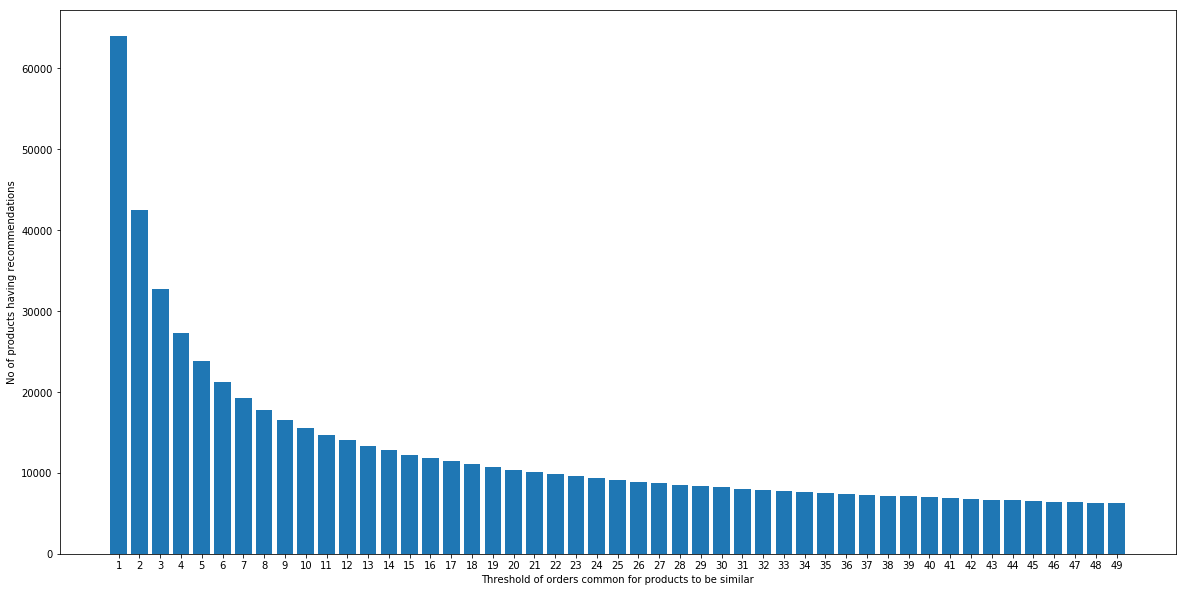

In [16]:
plt.figure(figsize=(20,10))
plt.xlabel('Threshold of orders common for products to be similar')
plt.ylabel('No of products having recommendations')
plt.bar(range(len(data)), data.values(), align='center')
plt.xticks(range(len(data)), list(data.keys()))

plt.show()

Using orders threshold of 2 for products to be similar

In [17]:
final_df = final_df[final_df['order_count'] >= 2]

In [18]:
len(final_df)

4951218

Parallizing dataframe operations

In [19]:
from multiprocessing import Pool
import numpy as np

def parallelize_dataframe(df, func, num_partitions, num_cores):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Computing orders Union and different similarities

In [20]:
def compute_orders_union_len(data):
    data['order_union'] = data.apply(lambda row : product_2_orders_cnt[row['product_id_x']] + product_2_orders_cnt[row['product_id_y']] - row['order_count'], axis=1)
    return data
final_df = parallelize_dataframe(final_df, compute_orders_union_len, 40, 16)

In [21]:
import math 

def compute_similarity(data):
    data['direct_similarity'] = data.apply(lambda row: row['order_count']/row['order_union'], axis=1)
    data['log_similarity'] = data.apply(lambda row: row['order_count']/math.log(row['order_union']), axis=1)
    data['sqrt_similarity'] = data.apply(lambda row: row['order_count']/math.sqrt(row['order_union']), axis=1)
    return data

final_df = parallelize_dataframe(final_df, compute_similarity, 40, 16)

In [22]:
final_df.rename(index=str, columns={'order_count':'order_intersection'}, inplace=True)
final_df.head()

,product_id_x,product_id_y,order_intersection,order_union,direct_similarity,log_similarity,sqrt_similarity
6,249,252,5,123,0.040650,1.039029,0.450835
7,249,1295,2,24,0.083333,0.629316,0.408248
11,249,19914,4,443,0.009029,0.656430,0.190046
13,249,76006,2,366,0.005464,0.338832,0.104542
14,249,134149,2,1225,0.001633,0.281266,0.057143


# Get Recommendations function

Compute Recommendation

In [23]:
import sys
sys.path.append("/nykaa/api")
from pas.v2.utils import Utils

def get_recommendations(product_id, recommendations_cnt=10, with_name=True, algo='coccurence_direct'):
    if algo == 'coccurence_log':
        temp_df = final_df[(final_df['product_id_x'] == product_id)  | (final_df['product_id_y'] == product_id)].sort_values(['log_similarity'], ascending=[0])
    elif algo == 'coccurence_sqrt':
        temp_df = final_df[(final_df['product_id_x'] == product_id)  | (final_df['product_id_y'] == product_id)].sort_values(['sqrt_similarity'], ascending=[0])
    elif algo == 'coccurence_direct':
        temp_df = final_df[(final_df['product_id_x'] == product_id)  | (final_df['product_id_y'] == product_id)].sort_values(['direct_similarity'], ascending=[0])
    else:
        temp_df = final_df[(final_df['product_id_x'] == product_id)  | (final_df['product_id_y'] == product_id)].sort_values(['order_intersection'], ascending=[0])
    rows = temp_df.values.tolist()
    recommendation_ids = []
    for row in rows:
        if row[0] == product_id:
            recommendation_ids.append(row[1])
        elif row[1] == product_id:
            recommendation_ids.append(row[0])
    recommendation_ids = recommendation_ids[:recommendations_cnt]
    if not with_name:
        return recommendation_ids
    query = {
        "query": {
            "terms": {"product_id.keyword": recommendation_ids}
        },
        "_source": ['title_text_split', 'product_id']
    }
    response = Utils.makeESRequest(query, index='livecore')
    product_id_2_name = {int(hit['_source']['product_id']):hit['_source']['title_text_split'] for hit in response['hits']['hits']}
    return [(recommendation_id, product_id_2_name[recommendation_id]) for recommendation_id in recommendation_ids]

In [24]:
final_df.to_csv('fbt_item_similarity.csv', encoding='utf-8', index=False)

# Preparing dictionary of similar products

In [25]:
final_df.head()

,product_id_x,product_id_y,order_intersection,order_union,direct_similarity,log_similarity,sqrt_similarity
6,249,252,5,123,0.040650,1.039029,0.450835
7,249,1295,2,24,0.083333,0.629316,0.408248
11,249,19914,4,443,0.009029,0.656430,0.190046
13,249,76006,2,366,0.005464,0.338832,0.104542
14,249,134149,2,1225,0.001633,0.281266,0.057143


In [26]:
from collections import defaultdict

simple_similar_products_dict = {}
direct_similar_products_dict = {}
log_similar_products_dict = {}
sqrt_similar_products_dict = {}

for row in final_df.values.tolist():
    if not row[0] in simple_similar_products_dict:
        simple_similar_products_dict[row[0]] = [] 
    if not row[1] in simple_similar_products_dict:
        simple_similar_products_dict[row[1]] = []
    
    if not row[0] in direct_similar_products_dict:
        direct_similar_products_dict[row[0]] = [] 
    if not row[1] in direct_similar_products_dict:
        direct_similar_products_dict[row[1]] = []
        
    if not row[0] in log_similar_products_dict:
        log_similar_products_dict[row[0]] = [] 
    if not row[1] in log_similar_products_dict:
        log_similar_products_dict[row[1]] = []
        
    if not row[0] in sqrt_similar_products_dict:
        sqrt_similar_products_dict[row[0]] = [] 
    if not row[1] in sqrt_similar_products_dict:
        sqrt_similar_products_dict[row[1]] = []
        
    
    simple_similar_products_dict[row[0]].append((row[1], row[2]))
    simple_similar_products_dict[row[1]].append((row[0], row[2]))
    
    direct_similar_products_dict[row[0]].append((row[1], row[4]))
    direct_similar_products_dict[row[1]].append((row[0], row[4]))
    
    log_similar_products_dict[row[0]].append((row[1], row[5]))
    log_similar_products_dict[row[1]].append((row[0], row[5]))
    
    sqrt_similar_products_dict[row[0]].append((row[1], row[6]))
    sqrt_similar_products_dict[row[1]].append((row[0], row[6]))

# Adding Data to MYSQL

In [27]:
%%time
import sys
sys.path.append('/nykaa/api')
from pas.v2.utils import Utils

pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()

create_recommendations_table_query = """create table if not exists recommendations_fbt_panda (
                        entity_id int unsigned not null,
                        entity_type varchar(50),
                        recommendation_type varchar(50),
                        algo varchar(50),
                        recommended_products_json JSON,
                        PRIMARY KEY (entity_id, entity_type, recommendation_type, algo)
                    )
"""

cursor.execute(create_recommendations_table_query)

def add_recommendations_in_mysql(db, cursor, rows):
    values_str = ", ".join(["(%s, %s, %s, %s, %s)" for i in range(len(rows))])
    values = tuple([str(data) for row in rows for data in row])
    insert_recommendations_query = """insert into recommendations_fbt_panda(entity_id, entity_type, 
                recommendation_type, algo, recommended_products_json) values %s on duplicate key 
                update recommended_products_json = values(recommended_products_json)
    """ %values_str
    cursor.execute(insert_recommendations_query, values)
    db.commit()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 79.3 ms


In [46]:
%%time
import sys
sys.path.append('/nykaa/api')
from pas.v2.utils import Utils

pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()

rows = []
products_count = 0

for product_id in unique_products:
    if not simple_similar_products_dict[product_id]:
        continue
    simple_similar_products = list(map(lambda e:e[0], sorted(simple_similar_products_dict[product_id],key=lambda e:e[1],reverse=True)[:20]))
    direct_similar_products = list(map(lambda e:e[0], sorted(direct_similar_products_dict[product_id],key=lambda e:e[1],reverse=True)[:20]))
    log_similar_products = list(map(lambda e:e[0], sorted(log_similar_products_dict[product_id],key=lambda e:e[1],reverse=True)[:20]))
    sqrt_similar_products = list(map(lambda e:e[0], sorted(sqrt_similar_products_dict[product_id],key=lambda e:e[1],reverse=True)[:20]))
   
    rows.append((product_id,'product','fbt','coccurence_simple',str(simple_similar_products)))
    rows.append((product_id,'product','fbt','coccurence_direct',str(direct_similar_products)))
    rows.append((product_id,'product','fbt','coccurence_log',str(log_similar_products)))
    rows.append((product_id,'product','fbt','coccurence_sqrt',str(sqrt_similar_products)))
    
    products_count += 1
    if len(rows) == 40:
        add_recommendations_in_mysql(pasdb, cursor, rows)
        rows = []
add_recommendations_in_mysql(pasdb, cursor, rows)

cursor.close()
pasdb.close()
print(products_count)

6222
CPU times: user 13.8 s, sys: 36 ms, total: 13.9 s
Wall time: 16.4 s


# Writing data for simple variants from configurable products using mysql

In [53]:
%%time
import json

nykaadb = Utils.nykaaMysqlConnection()
nykaa_cursor = nykaadb.cursor()
query = "select parent_id, child_id from catalog_product_relation"
nykaa_cursor.execute(query) 

parent_2_children = {}
for row in nykaa_cursor.fetchall():
    if not row[0] in parent_2_children:
        parent_2_children[row[0]] = []
    parent_2_children[row[0]].append(row[1])

with open("child_product_2_parent.json", "r+") as f:
    for key, value in json.load(f).items():
        value = int(value)
        if not value in parent_2_children:
            parent_2_children[value] = []
        parent_2_children[value].append(int(key))

pasdb = Utils.mysqlConnection('w')
cursor = pasdb.cursor()
products_count = 0
for parent, variants in parent_2_children.items():
    if not parent in simple_similar_products_dict:
        continue
    simple_similar_products = list(map(lambda e: e[0], sorted(simple_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    direct_similar_products = list(map(lambda e: e[0], sorted(direct_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    log_similar_products = list(map(lambda e: e[0], sorted(log_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))
    sqrt_similar_products = list(map(lambda e: e[0], sorted(sqrt_similar_products_dict[parent], key=lambda e: e[1], reverse=True)[:50]))

    rows = []
    for variant in variants:
        rows.append((variant, 'product', 'fbt', 'coccurence_simple', str(simple_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_direct', str(direct_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_log', str(log_similar_products)))
        rows.append((variant, 'product', 'fbt', 'coccurence_sqrt', str(sqrt_similar_products)))
        products_count += 1
    
    add_recommendations_in_mysql(pasdb, cursor, rows)

nykaa_cursor.close()
nykaadb.close()

cursor.close()
pasdb.close() 
print(products_count)

124267


# Writing data for variants of configurable products using ES